<a href="https://colab.research.google.com/github/x1ew/CT-KIDNEY/blob/main/CT_KIDNEY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***import Data***

In [ ]:
# !pip install -q kaggle
# from google.colab import files
# files.upload()
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

# from google.colab import drive
# drive.mount('/content/drive')

# !kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
# !cp ct-kidney-dataset-normal-cyst-tumor-and-stone.zip /content/drive/MyDrive

In [ ]:
!gdown '1uKu4xu7LwAZEfMg13M19thxxPvsU4d8s'
!unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Streaming output truncated to the last 5000 lines.
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-N

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, ConfusionMatrixDisplay
from matplotlib import pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#***Dataset and Dataloader***

In [ ]:
def train_valid_loader(data_dir, batch_size, augment, valid_size, size):
    #transforms
    valid_transform = transforms.Compose([transforms.Resize([size,size]),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
                                 ])
    if augment:
        train_transform = transforms.Compose([transforms.Resize([size,size]),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
                                 ])
    else:
        train_transform = transforms.Compose([transforms.Resize([size,size]),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
                                 ])

    # load the dataset
    train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform,)

    valid_dataset = datasets.ImageFolder(root=data_dir, transform=valid_transform,)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler,)

    return (train_loader, valid_loader)

In [ ]:
train_loader, test_loader = train_valid_loader("/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/",batch_size = 32,augment = False, valid_size=0.2, size=200)

#***Analys***

In [ ]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 12446
    Root location: /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/
    StandardTransform
Transform: Compose(
               Resize(size=[200, 200], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
test_loader.dataset

Dataset ImageFolder
    Number of datapoints: 12446
    Root location: /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/
    StandardTransform
Transform: Compose(
               Resize(size=[200, 200], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
train_loader.dataset[100]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]), 0)

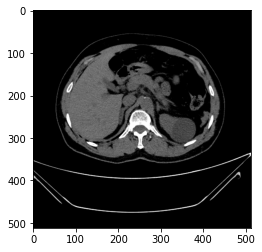

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (100).jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
img.shape

(512, 512, 3)

In [ ]:
from PIL import Image
img = Image.open('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1000).jpg')
img.size

(512, 512)

In [ ]:
df = pd.read_csv('kidneyData.csv')
df["Class"].unique()

array(['Tumor', 'Normal', 'Stone', 'Cyst'], dtype=object)

In [ ]:
# df.head()

In [ ]:
!ls /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst-\ \(1000\).jpg

#***Utility functions***

In [ ]:
def train(model, trainloader, loss_fn, optimizer, n):
    correct = 0
    losses = []
    model.train()
    for X, y in trainloader:  
        X = X.to(device)
        y = y.to(device)      
        # Compute prediction and loss
        optimizer.zero_grad()
        output = model(X)
        _, predict = torch.max(output, 1)
        correct += torch.sum(predict == y)
        
        loss = loss_fn(output, y)
        losses.append(loss.item())
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()
    return (correct.item() / n), np.mean(losses)

In [ ]:
def validation(model, testloader, loss_fn, n):
    correct = 0
    losses = []
    model.eval()
    with torch.no_grad():
        for X, y in testloader:
            X = X.to(device)
            y = y.to(device)      
            # Compute prediction and loss
            output = model(X)
            _, predict = torch.max(output, 1)
            correct += torch.sum(predict == y)

            loss = loss_fn(output, y)
            losses.append(loss.item())
    
    return (correct.item() / n), np.mean(losses)

In [ ]:
def fit(model, loss_fn, optimizer, EPOCHS):
    losses_train, losses_valid, acc_train, acc_valid, predicts = ([] for i in range(5))
    best_acc = 0

    for e in range(EPOCHS):
        train_c, train_l = train(model, train_loader, loss_fn, optimizer, len(train_loader.sampler))
        print(f"Epoch {e + 1} --- train accuracy {train_c * 100:.3f}    train losses {train_l:.3f}", end='')
        losses_train.append(train_l)  
        acc_train.append(train_c)  

        val_c, val_l = validation(model, test_loader, loss_fn, len(test_loader.sampler))
        print(f" --- valid accuracy {val_c * 100:.3f}   valid losses {val_l:.3f}")
        losses_valid.append(val_l)
        acc_valid.append(val_c)
    return losses_train, losses_valid, acc_train, acc_valid

In [ ]:
globprec, globrec, globf1 = 0, 0, 0

def show_metrics(model, dataloader, filename=None):
    global globprec, globrec, globf1
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X, y in dataloader:
            outputs = model(X.to(device))
            _, pred = torch.max(outputs, dim=1)
            y_pred.append(pred)
            y_true.append(y)
    y_pred = torch.cat(y_pred).cpu()
    y_true = torch.cat(y_true)
    creport = classification_report(y_true, y_pred)
    print(creport)
    globprec, globrec, globf1, _ = precision_recall_fscore_support(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    disp.plot()
    if filename:
        plt.savefig(filename)

In [ ]:
def plotplz(filename=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    # ax1.title("Training and Validation Accuracy")
    ax1.plot(acc_valid,label="val")
    ax1.plot(acc_train,label="train")
    ax1.set_xlabel("iterations")
    ax1.set_ylabel("accuracy")
    ax1.legend()

    ax2.plot(losses_valid,label="val")
    ax2.plot(losses_train,label="train")
    ax2.set_xlabel("iterations")
    ax2.set_ylabel("loss")
    ax2.legend()
    
    if filename:
        fig.savefig(filename)

#***Model-1***

##Without Augmentation

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 8, stride = 3, padding = 4, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 7, stride = 2, padding = 3, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 6, stride = 1, padding = 3, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, 4),
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,200,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 67, 67]           6,176
              ReLU-2           [-1, 32, 67, 67]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]         100,416
              ReLU-5             [-1, 64, 8, 8]               0
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Conv2d-7            [-1, 128, 5, 5]         295,040
              ReLU-8            [-1, 128, 5, 5]               0
         MaxPool2d-9            [-1, 128, 2, 2]               0
          Flatten-10                  [-1, 512]               0
          Dropout-11                  [-1, 512]               0
           Linear-12                    [-1, 4]           2,052
Total params: 403,684
Trainable params: 403,684
Non-trainable params: 0
-------------------------------

In [ ]:
model = FCModel().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, loss_fn, optimizer, 10)

Epoch 1 --- train accuracy 67.792    train losses 0.840 --- valid accuracy 80.434   valid losses 0.547
Epoch 2 --- train accuracy 86.592    train losses 0.399 --- valid accuracy 94.978   valid losses 0.221
Epoch 3 --- train accuracy 95.300    train losses 0.172 --- valid accuracy 97.589   valid losses 0.102
Epoch 4 --- train accuracy 98.032    train losses 0.088 --- valid accuracy 99.036   valid losses 0.048
Epoch 5 --- train accuracy 99.116    train losses 0.046 --- valid accuracy 99.598   valid losses 0.025
Epoch 6 --- train accuracy 99.578    train losses 0.024 --- valid accuracy 99.920   valid losses 0.012
Epoch 7 --- train accuracy 99.739    train losses 0.016 --- valid accuracy 99.799   valid losses 0.009
Epoch 8 --- train accuracy 99.940    train losses 0.008 --- valid accuracy 100.000   valid losses 0.006
Epoch 9 --- train accuracy 99.940    train losses 0.005 --- valid accuracy 100.000   valid losses 0.004
Epoch 10 --- train accuracy 99.990    train losses 0.003 --- valid accu

##Metrics & Plots

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2954
           1       1.00      1.00      1.00      4063
           2       1.00      1.00      1.00      1109
           3       1.00      1.00      1.00      1831

    accuracy                           1.00      9957
   macro avg       1.00      1.00      1.00      9957
weighted avg       1.00      1.00      1.00      9957



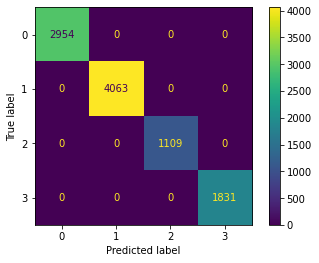

In [ ]:
show_metrics(model, train_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       755
           1       1.00      1.00      1.00      1014
           2       1.00      1.00      1.00       268
           3       1.00      1.00      1.00       452

    accuracy                           1.00      2489
   macro avg       1.00      1.00      1.00      2489
weighted avg       1.00      1.00      1.00      2489



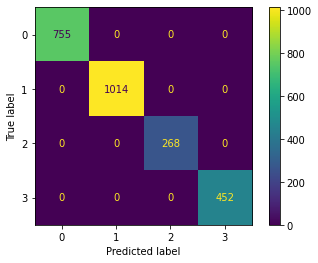

In [ ]:
show_metrics(model, test_loader)

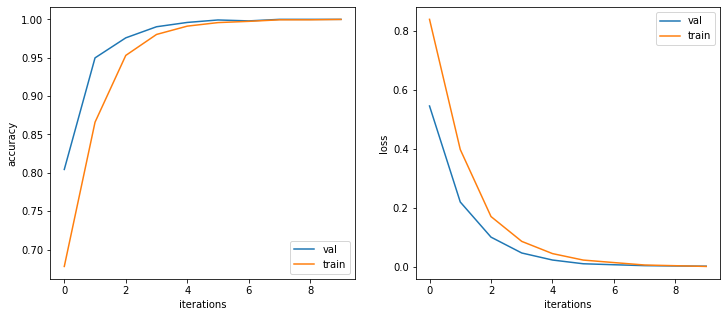

In [ ]:
plotplz()

##Augmentation

In [ ]:
train_loader, test_loader = train_valid_loader("/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/",batch_size = 32,augment = True, valid_size=0.2, size=250)

In [ ]:
class FCModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.modelfc = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 8, stride = 3, padding = 4, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 7, stride = 2, padding = 3, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 6, stride = 2, padding = 3, dilation = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
        )
    def forward(self, x):
        return self.modelfc(x)

In [ ]:
summary(FCModel().to(device), (3,250,250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 84, 84]           6,176
              ReLU-2           [-1, 32, 84, 84]               0
         MaxPool2d-3           [-1, 32, 21, 21]               0
            Conv2d-4           [-1, 64, 11, 11]         100,416
              ReLU-5           [-1, 64, 11, 11]               0
         MaxPool2d-6             [-1, 64, 5, 5]               0
            Conv2d-7            [-1, 128, 3, 3]         295,040
              ReLU-8            [-1, 128, 3, 3]               0
         MaxPool2d-9            [-1, 128, 1, 1]               0
          Flatten-10                  [-1, 128]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                    [-1, 4]             516
Total params: 402,148
Trainable params: 402,148
Non-trainable params: 0
-------------------------------

In [ ]:
model = FCModel().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, loss_fn, optimizer, 15)

Epoch 1 --- train accuracy 57.768    train losses 1.070 --- valid accuracy 64.564   valid losses 0.971
Epoch 2 --- train accuracy 63.945    train losses 0.930 --- valid accuracy 48.534   valid losses 1.128
Epoch 3 --- train accuracy 66.345    train losses 0.868 --- valid accuracy 50.703   valid losses 1.064
Epoch 4 --- train accuracy 68.203    train losses 0.826 --- valid accuracy 54.239   valid losses 1.025
Epoch 5 --- train accuracy 69.218    train losses 0.788 --- valid accuracy 42.186   valid losses 1.490
Epoch 6 --- train accuracy 70.393    train losses 0.759 --- valid accuracy 49.699   valid losses 1.158
Epoch 7 --- train accuracy 71.467    train losses 0.725 --- valid accuracy 53.676   valid losses 1.024
Epoch 8 --- train accuracy 72.431    train losses 0.695 --- valid accuracy 45.078   valid losses 1.321
Epoch 9 --- train accuracy 73.205    train losses 0.683 --- valid accuracy 48.413   valid losses 1.195
Epoch 10 --- train accuracy 74.631    train losses 0.649 --- valid accura

##Metrics & Plots

              precision    recall  f1-score   support

           0       0.75      0.96      0.84      2927
           1       0.86      0.88      0.87      4130
           2       0.56      0.34      0.42      1097
           3       0.74      0.54      0.62      1803

    accuracy                           0.78      9957
   macro avg       0.73      0.68      0.69      9957
weighted avg       0.77      0.78      0.77      9957



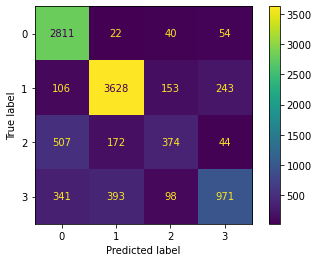

In [ ]:
show_metrics(model, train_loader)

              precision    recall  f1-score   support

           0       0.96      0.28      0.43       782
           1       0.58      1.00      0.73       947
           2       0.25      0.30      0.27       280
           3       0.29      0.17      0.21       480

    accuracy                           0.53      2489
   macro avg       0.52      0.44      0.41      2489
weighted avg       0.60      0.53      0.49      2489



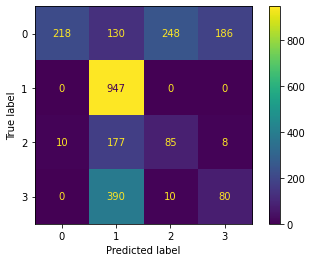

In [ ]:
show_metrics(model, test_loader)

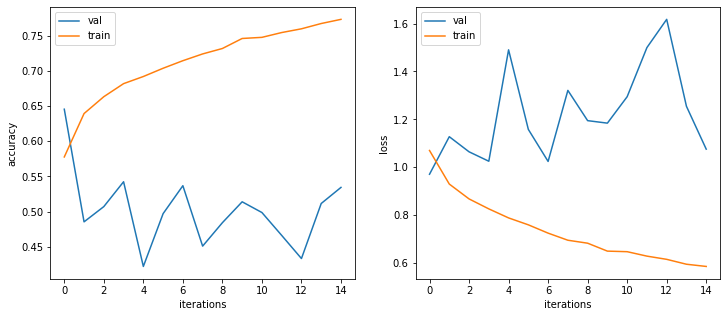

In [ ]:
plotplz()

#***Model-2***


##Resnet

In [ ]:
from torchvision.models import resnet18

model = resnet18(progress=False, pretrained=True).to(device)
model.fc = nn.Linear(512, 4).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
summary(model, (3,200,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]          36,864
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
       BasicBlock-11           [-1, 64, 50, 50]               0
           Conv2d-12           [-1, 64, 50, 50]          36,864
      BatchNorm2d-13           [-1, 64, 50, 50]             128
             ReLU-14           [-1, 64,

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, loss_fn, optimizer, 5)

Epoch 1 --- train accuracy 96.997    train losses 0.093 --- valid accuracy 100.000   valid losses 0.002
Epoch 2 --- train accuracy 99.930    train losses 0.006 --- valid accuracy 100.000   valid losses 0.000
Epoch 3 --- train accuracy 99.950    train losses 0.005 --- valid accuracy 99.719   valid losses 0.014
Epoch 4 --- train accuracy 99.096    train losses 0.035 --- valid accuracy 99.879   valid losses 0.004
Epoch 5 --- train accuracy 99.970    train losses 0.002 --- valid accuracy 100.000   valid losses 0.000


##Metrics & Plots

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2946
           1       1.00      1.00      1.00      4089
           2       1.00      1.00      1.00      1081
           3       1.00      1.00      1.00      1841

    accuracy                           1.00      9957
   macro avg       1.00      1.00      1.00      9957
weighted avg       1.00      1.00      1.00      9957



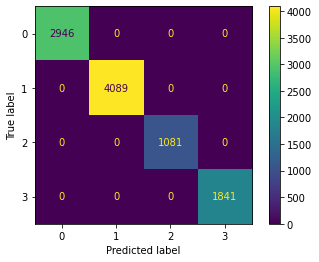

In [ ]:
show_metrics(model, train_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       763
           1       1.00      1.00      1.00       988
           2       1.00      1.00      1.00       296
           3       1.00      1.00      1.00       442

    accuracy                           1.00      2489
   macro avg       1.00      1.00      1.00      2489
weighted avg       1.00      1.00      1.00      2489



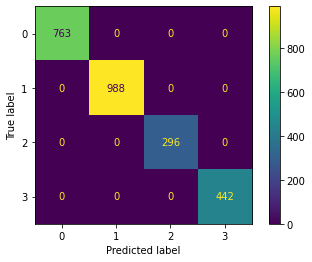

In [ ]:
show_metrics(model, test_loader)

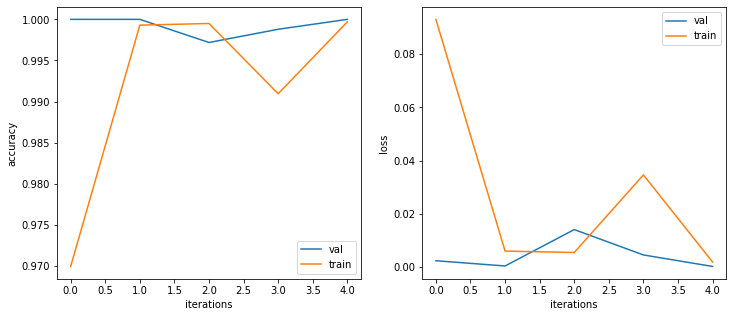

In [ ]:
plotplz()

#***Model-3***


##VGG

In [ ]:
from torchvision import models

model = models.vgg16(pretrained=True).to(device)
model.classifier[6] = nn.Linear(4096, 4).to(device)                   

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
summary(model, (3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,792
              ReLU-2         [-1, 64, 200, 200]               0
            Conv2d-3         [-1, 64, 200, 200]          36,928
              ReLU-4         [-1, 64, 200, 200]               0
         MaxPool2d-5         [-1, 64, 100, 100]               0
            Conv2d-6        [-1, 128, 100, 100]          73,856
              ReLU-7        [-1, 128, 100, 100]               0
            Conv2d-8        [-1, 128, 100, 100]         147,584
              ReLU-9        [-1, 128, 100, 100]               0
        MaxPool2d-10          [-1, 128, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]         295,168
             ReLU-12          [-1, 256, 50, 50]               0
           Conv2d-13          [-1, 256, 50, 50]         590,080
             ReLU-14          [-1, 256,

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
losses_train, losses_valid, acc_train, acc_valid = fit(model, loss_fn, optimizer, 5)

Epoch 1 --- train accuracy 90.288    train losses 0.258 --- valid accuracy 98.714   valid losses 0.040
Epoch 2 --- train accuracy 99.136    train losses 0.030 --- valid accuracy 98.875   valid losses 0.027
Epoch 3 --- train accuracy 99.096    train losses 0.031 --- valid accuracy 99.558   valid losses 0.017
Epoch 4 --- train accuracy 99.930    train losses 0.002 --- valid accuracy 99.960   valid losses 0.001
Epoch 5 --- train accuracy 99.528    train losses 0.018 --- valid accuracy 99.839   valid losses 0.004


##Metrics & Plots

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2946
           1       1.00      1.00      1.00      4089
           2       1.00      1.00      1.00      1081
           3       1.00      1.00      1.00      1841

    accuracy                           1.00      9957
   macro avg       1.00      1.00      1.00      9957
weighted avg       1.00      1.00      1.00      9957



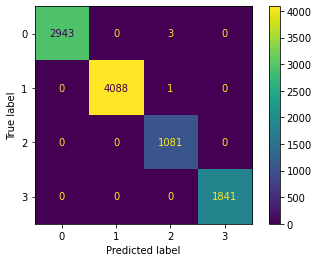

In [ ]:
show_metrics(model, train_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       763
           1       1.00      1.00      1.00       988
           2       0.99      1.00      1.00       296
           3       1.00      1.00      1.00       442

    accuracy                           1.00      2489
   macro avg       1.00      1.00      1.00      2489
weighted avg       1.00      1.00      1.00      2489



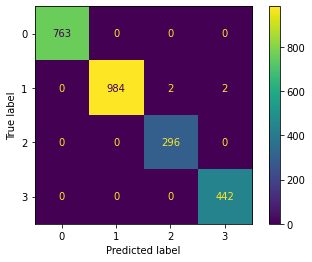

In [ ]:
show_metrics(model, test_loader)

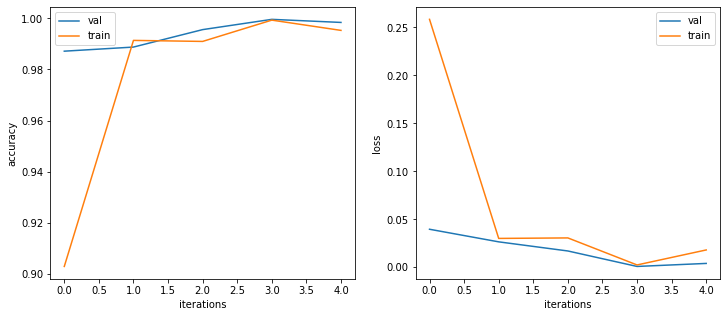

In [ ]:
plotplz()